## 0. Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score, ParameterGrid
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import statsmodels.api as sm
import pandas_ta as ta
import datetime
import itertools
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
from xgboost import XGBRegressor, plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error

## 1. Read data into Dataframe

In [2]:
df = pd.read_csv('../../long_short_local/raw_data/cleaned_data.csv')

In [3]:
# convert 'Date' column to datetime values
df['Date'] = pd.to_datetime(df['Date'].str[:10])

## 2. Create SMA (10, 20, 60 days)

In [4]:
sma_list = [10, 20, 60]

for sma in sma_list:
    if sma == 10:
        sma_10_df_prep = pd.DataFrame(df['Date'])

        for ratio in df.columns:
            test_df = df[['Date', ratio]]
            sma10 = pd.DataFrame(ta.sma(test_df[ratio], length=10))
            loop_df = pd.concat([test_df, sma10], axis=1, ignore_index=False)
            loop_df.rename(columns={'SMA_10': f'{ratio}_SMA_10'}, inplace=True)
            sma_10_df_prep = pd.concat([sma_10_df_prep, loop_df], axis=1, ignore_index=False)
            sma_10_df = sma_10_df_prep.iloc[:, 3:]
    
    elif sma == 20:
        sma_20_df_prep = pd.DataFrame(df['Date'])

        for ratio in df.columns:
            test_df = df[['Date', ratio]]
            sma20 = pd.DataFrame(ta.sma(test_df[ratio], length=20))
            loop_df = pd.concat([test_df, sma20], axis=1, ignore_index=False)
            loop_df.rename(columns={'SMA_20': f'{ratio}_SMA_20'}, inplace=True)
            sma_20_df_prep = pd.concat([sma_20_df_prep, loop_df], axis=1, ignore_index=False)
            sma_20_df = sma_20_df_prep.iloc[:, 3:]
    
    else:
        sma_60_df_prep = pd.DataFrame(df['Date'])

        for ratio in df.columns:
            test_df = df[['Date', ratio]]
            sma60 = pd.DataFrame(ta.sma(test_df[ratio], length=60))
            loop_df = pd.concat([test_df, sma60], axis=1, ignore_index=False)
            loop_df.rename(columns={'SMA_60': f'{ratio}_SMA_60'}, inplace=True)
            sma_60_df_prep = pd.concat([sma_60_df_prep, loop_df], axis=1, ignore_index=False)
            sma_60_df = sma_60_df_prep.iloc[:, 3:]

## 3. Create RSI 14

In [5]:
rsi_14_df_prep = pd.DataFrame(df['Date'])

for ratio in df.columns:
    test_df = df[['Date', ratio]]
    rsi14 = pd.DataFrame(ta.rsi(test_df[ratio], length=14))
    loop_df = pd.concat([test_df, rsi14], axis=1, ignore_index=False)
    loop_df.rename(columns={'RSI_14': f'{ratio}_RSI_14'}, inplace=True)
    rsi_14_df_prep = pd.concat([rsi_14_df_prep, loop_df], axis=1, ignore_index=False)
    rsi_14_df = rsi_14_df_prep.iloc[:, 3:]

In [6]:
# concatenate all 4 dataframse
concat_10_20_df = pd.concat([sma_10_df, sma_20_df], axis=1)
concat_10_20_60_df = pd.concat([concat_10_20_df, sma_60_df], axis=1)
combined_df = pd.concat([concat_10_20_60_df, rsi_14_df], axis=1)
# remove duplicates of 'Date' column
dropped_date_df = combined_df.loc[:,~combined_df.columns.duplicated()]
dropped_date_df.set_index('Date', inplace=True)
# sort the ratios by column name
sorted_df = dropped_date_df.reindex(sorted(dropped_date_df.columns, reverse=False), axis=1)

In [7]:
test_plot_df = sorted_df[['ALB_ZBRA', 'ALB_ZBRA_SMA_10', 'ALB_ZBRA_SMA_20', 'ALB_ZBRA_SMA_60']]

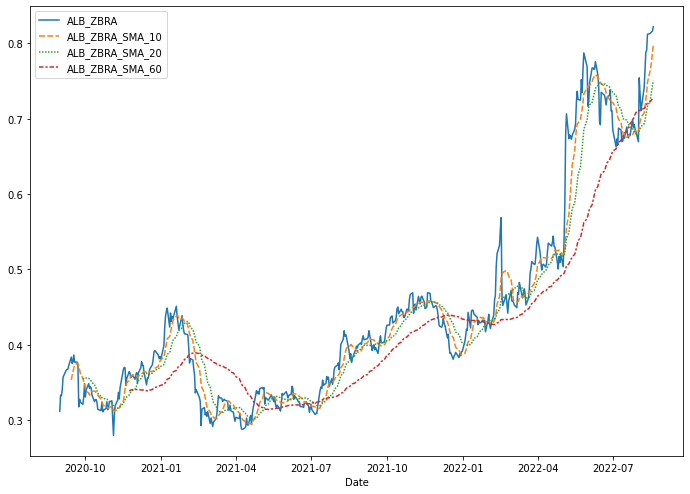

In [8]:
# test plot for the first ratio
dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=dims)
sns.lineplot(data=test_plot_df.iloc[:, :5]);

## 4. Clean dataframe

In [9]:
sorted_df = sorted_df.fillna(sorted_df.median())

## 5. Extract features with prophet

In [10]:
# full df
sorted_df.head()

,ALB_ZBRA,ALB_ZBRA_RSI_14,ALB_ZBRA_SMA_10,ALB_ZBRA_SMA_20,ALB_ZBRA_SMA_60,DE_BXP,DE_BXP_RSI_14,DE_BXP_SMA_10,DE_BXP_SMA_20,DE_BXP_SMA_60,...,PEG_O,PEG_O_RSI_14,PEG_O_SMA_10,PEG_O_SMA_20,PEG_O_SMA_60,SO_NLOK,SO_NLOK_RSI_14,SO_NLOK_SMA_10,SO_NLOK_SMA_20,SO_NLOK_SMA_60
Date,,,,,,,,,,,,,,,,,,,,,
2020-08-31,0.311845,53.506606,0.401902,0.40318,0.392237,2.548054,53.376443,3.24198,3.235732,3.211952,...,0.882281,49.875527,0.961826,0.966244,0.968382,2.136432,52.240503,2.629768,2.620719,2.571855
2020-09-01,0.332974,53.506606,0.401902,0.40318,0.392237,2.687319,53.376443,3.24198,3.235732,3.211952,...,0.855546,49.875527,0.961826,0.966244,0.968382,2.094566,52.240503,2.629768,2.620719,2.571855
2020-09-02,0.332368,53.506606,0.401902,0.40318,0.392237,2.629334,53.376443,3.24198,3.235732,3.211952,...,0.872526,49.875527,0.961826,0.966244,0.968382,2.125291,52.240503,2.629768,2.620719,2.571855
2020-09-03,0.339772,53.506606,0.401902,0.40318,0.392237,2.534974,53.376443,3.24198,3.235732,3.211952,...,0.848504,49.875527,0.961826,0.966244,0.968382,2.210971,52.240503,2.629768,2.620719,2.571855
2020-09-04,0.356920,53.506606,0.401902,0.40318,0.392237,2.536138,53.376443,3.24198,3.235732,3.211952,...,0.854765,49.875527,0.961826,0.966244,0.968382,2.152835,52.240503,2.629768,2.620719,2.571855


In [11]:
# for testing, we just extract one ratio
one_ratio_df = sorted_df.iloc[:, :5]

In [12]:
def prophet_features(df, horizon=95):
    temp_df = df.reset_index()
    temp_df = temp_df[['Date', 'ALB_ZBRA']]
    temp_df.rename(columns={'Date': 'ds', 'ALB_ZBRA': 'y'}, inplace=True)
    
    # take last week of the dataset for validation
    train_set, test_set = temp_df.iloc[:-horizon,:], temp_df.iloc[-horizon:,:]
    
    # define prophet model
    m = Prophet(
                growth='linear',
                seasonality_mode='additive',
                interval_width=0.95,
                daily_seasonality=True,
                weekly_seasonality=True,
                yearly_seasonality=False
            )
    # train prophet model
    m.fit(train_set)
    
    # extract features from data using prophet to predict train set
    predictions_train = m.predict(train_set.drop('y', axis=1))
    # extract features from data using prophet to predict test set
    predictions_test = m.predict(test_set.drop('y', axis=1))
    # merge train and test predictions
    predictions = pd.concat([predictions_train, predictions_test], axis=0)

    return predictions

In [13]:
proph_features = prophet_features(one_ratio_df)

Initial log joint probability = -4.16589
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       934.958    0.00179318       302.377      0.6565      0.6565      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        939.47     0.0289948       175.407           1           1      258   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     239       941.625    0.00100431       64.2297    1.68e-05       0.001      351  LS failed, Hessian reset 
     299       942.694   6.88617e-05       79.2144     0.03615           1      442   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     386       942.936   0.000376186       63.3895    6.89e-06       0.001      601  LS failed, Hessian reset 
     399        942.97   0.000606468       84.4355      0.3518           1      621   
    Iter      log pro

In [14]:
proph_features.head(2)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-08-31,0.314774,0.275212,0.384456,0.314774,0.314774,0.016589,0.016589,0.016589,0.01651,0.01651,0.01651,0.000079,0.000079,0.000079,0.0,0.0,0.0,0.331363
1,2020-09-01,0.315111,0.273640,0.391968,0.315111,0.315111,0.018305,0.018305,0.018305,0.01651,0.01651,0.01651,0.001795,0.001795,0.001795,0.0,0.0,0.0,0.333416


⬇️ ⬇️ ⬇️ ⬇️ ⬇️ ⬇️ ⬇️ ⬇️ ⬇️ ⬇️ ⬇️ ⬇️ ⬇️ ⬇️ ⬇️ ⬇️ ⬇️ ⬇️ ⬇️ ⬇️ ⬇️ ⬇️ ⬇️ ⬇️ ⬇️ ⬇️ ⬇️ ⬇️ ⬇️ ⬇️ ⬇️ ⬇️ ⬇️ ⬇️ ⬇️ ⬇️

## 6. Train XGBoost model

In [17]:
def train_xgb_with_prophet_features(df, horizon=95, lags=[1, 2, 3, 4, 5]):
    # create a dataframe with all the new features created with Prophet
    new_prophet_features = prophet_features(df, horizon=horizon)
    df.reset_index(inplace=True)
    
    # merge the Prophet features df with the first df
    df = pd.merge(df, new_prophet_features, left_on=['Date'], right_on=['ds'], how='inner')
    df.drop('ds', axis=1, inplace=True)
    df.set_index('Date', inplace=True)
    
    # create some lag variables using Prophet predictions (yhat column)
    for lag in lags:
        df[f'yhat_lag_{lag}'] = df['yhat'].shift(lag)
    df.dropna(axis=0, how='any')
    
    X = df.drop('ALB_ZBRA', axis=1)
    y = df['ALB_ZBRA']
    
    # take last week of the dataset for validation
    X_train, X_test = X.iloc[:-horizon,:], X.iloc[-horizon:,:]
    y_train, y_test = y.iloc[:-horizon], y.iloc[-horizon:]
    
    # define XGBoost model, train it and make predictions
    xgb_model = XGBRegressor()
    #model = XGBRegressor(random_state=42)
    xgb_model.fit(X_train, y_train)
    predictions = xgb_model.predict(X_test)
    
    #  compute MAE
    mae = np.round(mean_absolute_error(y_test, predictions), 3) 
    # compute MAPE
    #y_true, y_pred = np.array(y_test['y']), np.array(predictions)
    #mape = np.mean(np.abs((y_test - predictions) / y_test)) * 100
    
    # plot reality vs prediction for the last week of the dataset
    fig = plt.figure(figsize=(16,6))
    plt.title(f'Real vs Prediction - MAE {mae}', fontsize=20)
    plt.plot(y_test, color='red')
    plt.plot(pd.Series(predictions, index=y_test.index), color='green')
    plt.xlabel('date', fontsize=16)
    plt.ylabel('ratio', fontsize=16)
    plt.legend(labels=['Real', 'Prediction'], fontsize=16)
    plt.grid()
    plt.show()

Initial log joint probability = -4.16589
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       934.958    0.00179318       302.377      0.6565      0.6565      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        939.47     0.0289948       175.407           1           1      258   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     239       941.625    0.00100431       64.2297    1.68e-05       0.001      351  LS failed, Hessian reset 
     299       942.694   6.88617e-05       79.2144     0.03615           1      442   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     386       942.936   0.000376186       63.3895    6.89e-06       0.001      601  LS failed, Hessian reset 
     399        942.97   0.000606468       84.4355      0.3518           1      621   
    Iter      log pro

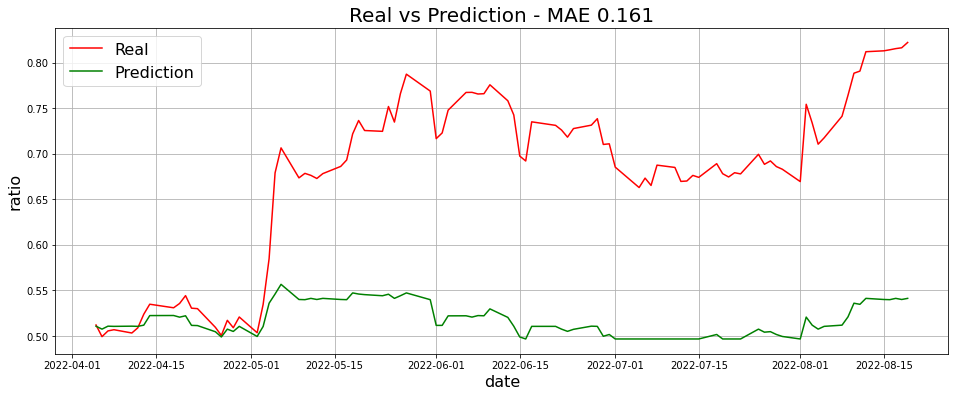

In [18]:
train_xgb_with_prophet_features(one_ratio_df)